## Can mlp learn to classifier clean modulated signals just as well as convnet?

In [27]:
import pickle
import matplotlib.pyplot as plt

In [28]:
with open('./Data/Unimpaired_diff_BW_mod22.pickle', 'rb') as f:
    data = pickle.load(f, encoding='latin1')

print(data.keys())

dict_keys(['oqpsk', 'gmsk', '64apsk', '2fsk', 'ook', '128apsk', '4fsk', '8psk', '16psk', 'bpsk', 'qam16', 'cpfsk', 'qam256', '256apsk', '16apsk', 'pam4', '32psk', 'gfsk', 'qam64', 'qpsk', '32apsk', 'qam32'])


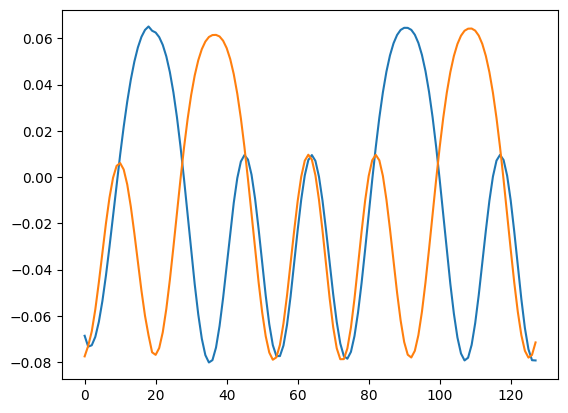

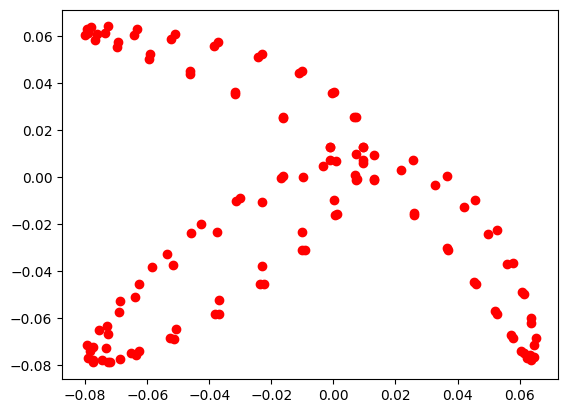

In [29]:
oqpsk = data['oqpsk']
plt.figure(1)
plt.plot(oqpsk[0].T)
plt.figure(2)
plt.scatter(oqpsk[0][0], oqpsk[0][1], c='r')

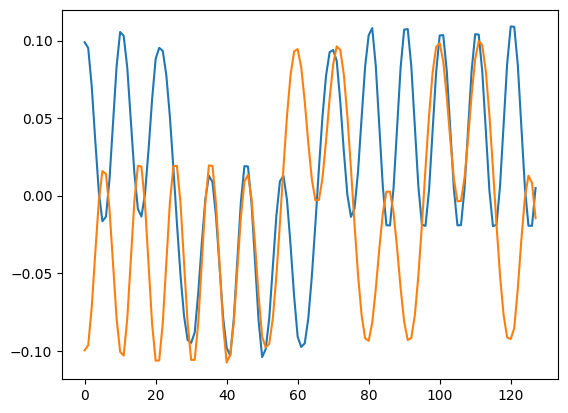

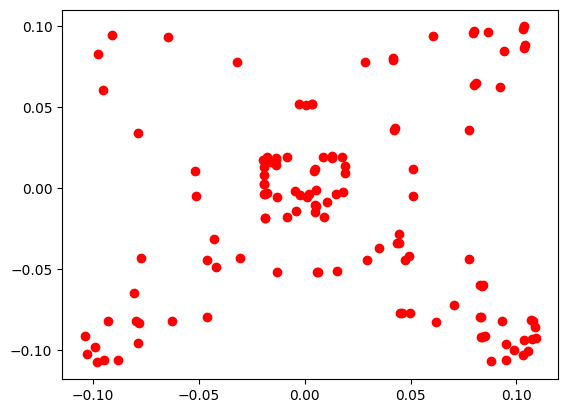

In [30]:
gmsk = data['gmsk']
plt.figure(1)
plt.plot(gmsk[0].T)
plt.figure(2)
plt.scatter(gmsk[0][0], gmsk[0][1], c='r')

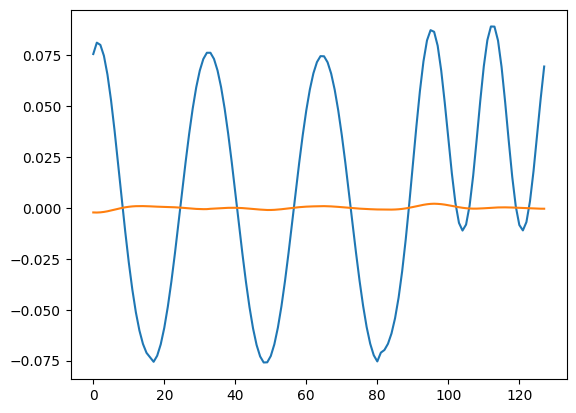

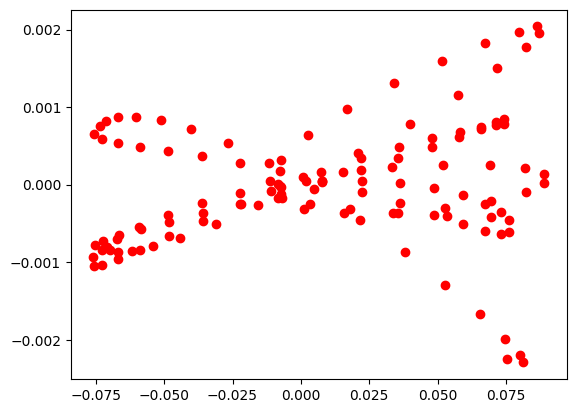

In [31]:
bpsk = data['bpsk']
plt.figure(1)
plt.plot(bpsk[0].T)
plt.figure(2)
plt.scatter(bpsk[0][0], bpsk[0][1], c='r')

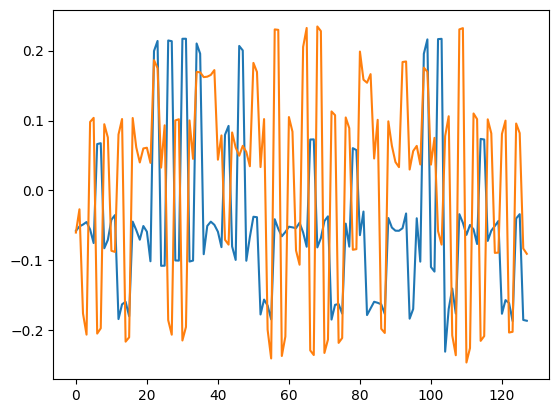

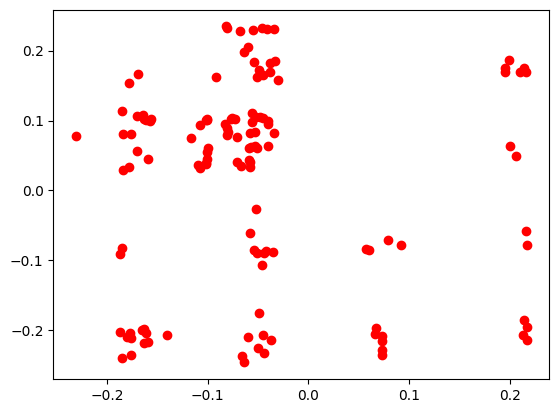

In [32]:
qam16 = data['qam16']
plt.figure(1)
plt.plot(qam16[0].T)
plt.figure(2)
plt.scatter(qam16[0][0], qam16[0][1], c='r')

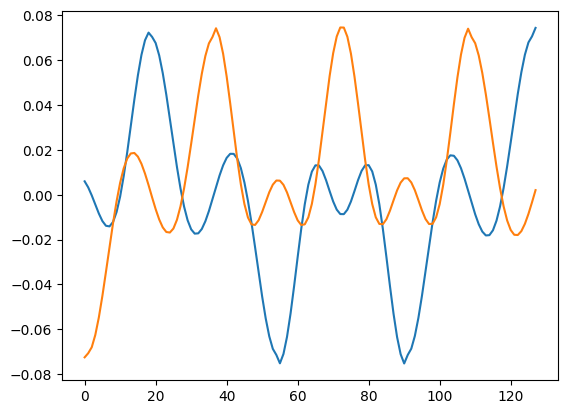

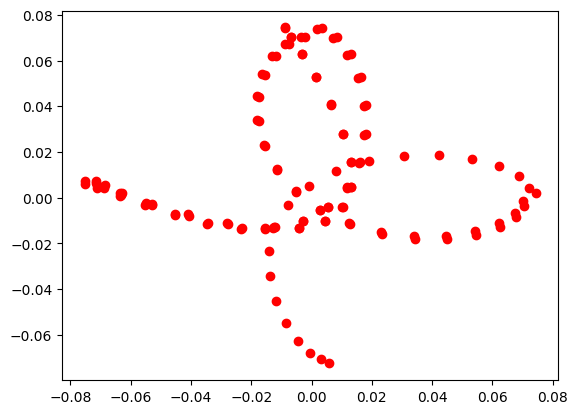

In [33]:
fsk4 = data['4fsk']
plt.figure(1)
plt.plot(fsk4[0].T)
plt.figure(2)
plt.scatter(fsk4[0][0], fsk4[0][1], c='r')

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision.transforms import Compose, Lambda

import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [36]:
class IQDataset(Dataset):
    def __init__(self, data, labels, data_transform=None):
        self.data = data
        self.labels = labels
        self.data_transform = data_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        labels = self.labels[idx]
        if self.data_transform:
            data = self.data_transform(data)
        elif isinstance(data, np.ndarray):
            data = torch.from_numpy(data).float()
        return data, labels

In [37]:
labels = data.keys()
X = np.concatenate([data[label] for label in labels])
y = np.concatenate([np.ones(data[label].shape[0]) *
                   i for i, label in enumerate(labels)])
X.shape, y.shape

((219912, 2, 128), (219912,))

In [38]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
train_idx, test_idx = next(sss.split(X, y))

In [39]:
MLP_txfm = Compose([
    Lambda(lambda x: torch.tensor(x).float()),
    Lambda(lambda x: x.view(-1))
])

dataset = IQDataset(X[train_idx], y[train_idx], data_transform=MLP_txfm)

train_dataset, val_dataset = random_split(
    dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [40]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, hidden_features)
        self.fc3 = nn.Linear(hidden_features, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [41]:
class ConvNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, 16, 5, padding='same')
        self.conv2 = nn.Conv1d(16, 32, 5, padding='same')
        self.maxpool = nn.MaxPool1d(2)  # 2x downsampling
        self.fc1 = nn.Linear(1024, num_classes)  # 128 / 4 * 32 = 1024

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [42]:
def train_one_epoch(model, optimizer, criterion, train_loader):
    model.train()
    avg_loss = 0.
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, labels.long())
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
    return avg_loss / len(train_loader)


def validate(model, criterion, val_loader):
    model.eval()
    avg_loss = 0.
    correct = 0
    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            output = model(data)
            avg_loss += criterion(output, labels.long()).item()
            pred = F.softmax(output, dim=-1).argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()
    return avg_loss / len(val_loader), correct / len(val_loader.dataset)

In [43]:
class Tracker:
    def __init__(self, metric, mode='auto'):
        self.metric = metric
        self.mode = mode
        self.mode_dict = {
            'auto': np.less if 'loss' in metric else np.greater,
            'min': np.less,
            'max': np.greater
        }
        self.operator = self.mode_dict[mode]

        self._best = np.inf if 'loss' in metric else -np.inf

    @property
    def best(self):
        return self._best

    @best.setter
    def best(self, value):
        self._best = value

In [44]:
NUM_EPOCHS = 50

model = MLP(in_features=2*128, hidden_features=256,
            out_features=len(labels)).to(device)
optimizer = torch.optim.Adam(
    model.parameters(), lr=1e-3, weight_decay=5e-4)  # L2 regularization
criterion = nn.CrossEntropyLoss()
tracker = Tracker('val_loss')

print(f'Model has {sum(p.numel() for p in model.parameters())} parameters')


history = {
    'train_loss': [],
    'val_loss': [],
    'val_acc': []
}
for epoch in range(NUM_EPOCHS):
    train_loss = train_one_epoch(model, optimizer, criterion, train_loader)
    val_loss, val_acc = validate(model, criterion, val_loader)
    print(
        f'Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val Acc: {val_acc}')

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    if tracker.operator(val_loss, tracker.best):
        tracker.best = val_loss
        torch.save(model.state_dict(), './Models/best_mlp.pth')
        print('Model saved with val loss:',
              val_loss, 'at ./Models/best_mlp.pth')

Model has 137238 parameters
Epoch 0, Train Loss: 1.5374527312031223, Val Loss: 1.174192016741197, Val Acc: 0.605073405222814
Model saved with val loss: 1.174192016741197 at ./Models/best_mlp.pth
Epoch 1, Train Loss: 1.0565946272408135, Val Loss: 0.9838634078871548, Val Acc: 0.6595426789658309
Model saved with val loss: 0.9838634078871548 at ./Models/best_mlp.pth
Epoch 2, Train Loss: 0.9144472695536724, Val Loss: 0.8978868533827187, Val Acc: 0.6837404183448097
Model saved with val loss: 0.8978868533827187 at ./Models/best_mlp.pth
Epoch 3, Train Loss: 0.8443075458348092, Val Loss: 0.8517410799102744, Val Acc: 0.6997531505781474
Model saved with val loss: 0.8517410799102744 at ./Models/best_mlp.pth
Epoch 4, Train Loss: 0.8018891648925351, Val Loss: 0.8265247595953916, Val Acc: 0.7076133558529297
Model saved with val loss: 0.8265247595953916 at ./Models/best_mlp.pth
Epoch 5, Train Loss: 0.7734160682974806, Val Loss: 0.8191302797195201, Val Acc: 0.7081005586592178
Model saved with val loss:

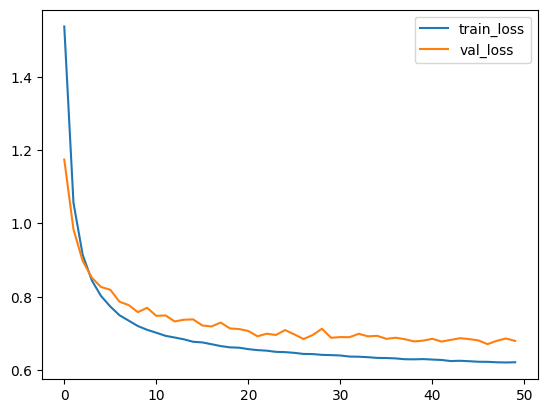

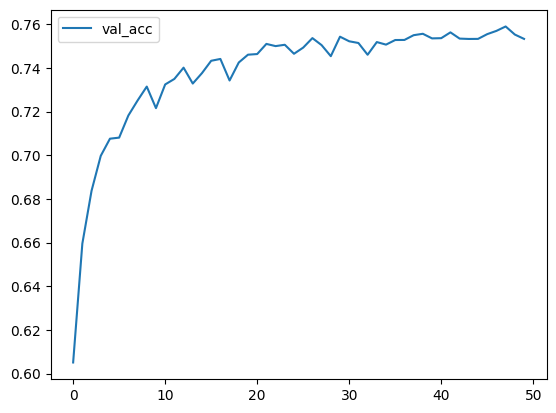

In [45]:
plt.figure(1)
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()

plt.figure(2)
plt.plot(history['val_acc'], label='val_acc')
plt.legend()

In [46]:
dataset = IQDataset(X[train_idx], y[train_idx])

train_dataset, val_dataset = random_split(
    dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [47]:
model = ConvNet(in_channels=2, num_classes=len(labels)).to(device)
optimizer = torch.optim.Adam(
    model.parameters(), lr=1e-3, weight_decay=5e-4)  # L2 regularization
criterion = nn.CrossEntropyLoss()
tracker = Tracker('val_loss')

print(f'Model has {sum(p.numel() for p in model.parameters())} parameters')


history = {
    'train_loss': [],
    'val_loss': [],
    'val_acc': []
}
for epoch in range(NUM_EPOCHS):
    train_loss = train_one_epoch(model, optimizer, criterion, train_loader)
    val_loss, val_acc = validate(model, criterion, val_loader)
    print(
        f'Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val Acc: {val_acc}')

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    if tracker.operator(val_loss, tracker.best):
        tracker.best = val_loss
        torch.save(model.state_dict(), './Models/best_convnet.pth')
        print('Model saved with val loss:',
              val_loss, 'at ./Models/best_convnet.pth')

Model has 25318 parameters
Epoch 0, Train Loss: 1.5035233854101553, Val Loss: 1.1265492247396294, Val Acc: 0.6386579186696115
Model saved with val loss: 1.1265492247396294 at ./Models/best_convnet.pth
Epoch 1, Train Loss: 0.9939782235042619, Val Loss: 0.8908661828915031, Val Acc: 0.7023840457321034
Model saved with val loss: 0.8908661828915031 at ./Models/best_convnet.pth
Epoch 2, Train Loss: 0.8353282560672535, Val Loss: 0.7940981756984754, Val Acc: 0.7276536312849162
Model saved with val loss: 0.7940981756984754 at ./Models/best_convnet.pth
Epoch 3, Train Loss: 0.7462510570949565, Val Loss: 0.7543433858226765, Val Acc: 0.7408730674288684
Model saved with val loss: 0.7543433858226765 at ./Models/best_convnet.pth
Epoch 4, Train Loss: 0.6884977312506437, Val Loss: 0.6883596751920159, Val Acc: 0.7612056645446278
Model saved with val loss: 0.6883596751920159 at ./Models/best_convnet.pth
Epoch 5, Train Loss: 0.6455298900859763, Val Loss: 0.6610975813271472, Val Acc: 0.7760491100428738
Mode

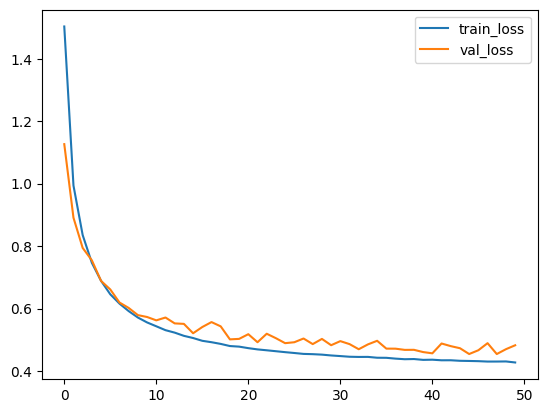

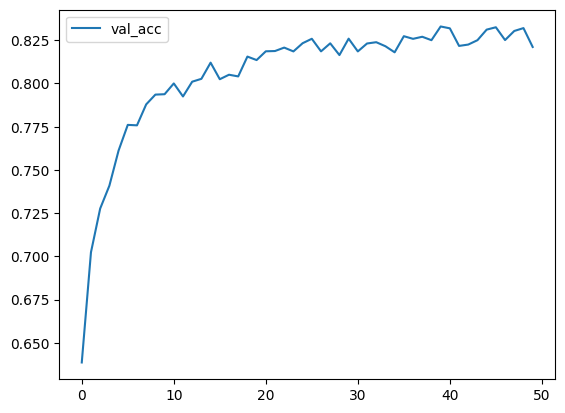

In [48]:
plt.figure(1)
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()

plt.figure(2)
plt.plot(history['val_acc'], label='val_acc')
plt.legend()

## Testing

In [62]:
results = {
    "mlp": {
        'preds': [],
        'labels': []
    },
    "convnet": {
        'preds': [],
        'labels': []
    }
}
test_dataset = IQDataset(X[test_idx], y[test_idx], data_transform=MLP_txfm)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


model = MLP(in_features=2*128, hidden_features=256,
            out_features=22)
model.load_state_dict(torch.load('./Models/best_mlp.pth', weights_only=True))

model = model.to(device)

model.eval()
with torch.no_grad():
    for data, labels in test_dataloader:
        data, labels = data.to(device), labels.to(device)
        output = model(data)
        pred = F.softmax(output, dim=-1).argmax(dim=1, keepdim=True)
        results['mlp']['preds'].extend(pred.cpu().numpy())
        results['mlp']['labels'].extend(labels.cpu().numpy())

test_dataset = IQDataset(X[test_idx], y[test_idx])
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = ConvNet(in_channels=2, num_classes=22).to(device)
model.load_state_dict(
    torch.load('./Models/best_convnet.pth', weights_only=True))

model.eval()
with torch.no_grad():
    for data, labels in test_dataloader:
        data, labels = data.to(device), labels.to(device)
        output = model(data)
        pred = F.softmax(output, dim=-1).argmax(dim=1, keepdim=True)
        results['convnet']['preds'].extend(pred.cpu().numpy())
        results['convnet']['labels'].extend(labels.cpu().numpy())

Performance of mlp
              precision    recall  f1-score   support

       oqpsk       0.94      0.96      0.95      2999
        gmsk       0.52      0.78      0.62      2999
      64apsk       0.62      0.52      0.57      2999
        2fsk       0.49      0.97      0.65      2999
         ook       0.98      0.99      0.99      2999
     128apsk       0.75      0.52      0.62      2999
        4fsk       0.70      0.86      0.77      2999
        8psk       0.70      0.71      0.71      2999
       16psk       0.84      0.87      0.86      2999
        bpsk       0.96      0.99      0.97      2999
       qam16       0.85      0.94      0.89      2998
       cpfsk       0.33      0.03      0.06      2999
      qam256       0.90      0.96      0.93      2999
     256apsk       0.76      0.91      0.83      2998
      16apsk       0.75      0.75      0.75      2998
        pam4       1.00      0.99      1.00      2999
       32psk       0.70      0.74      0.72      2999
        

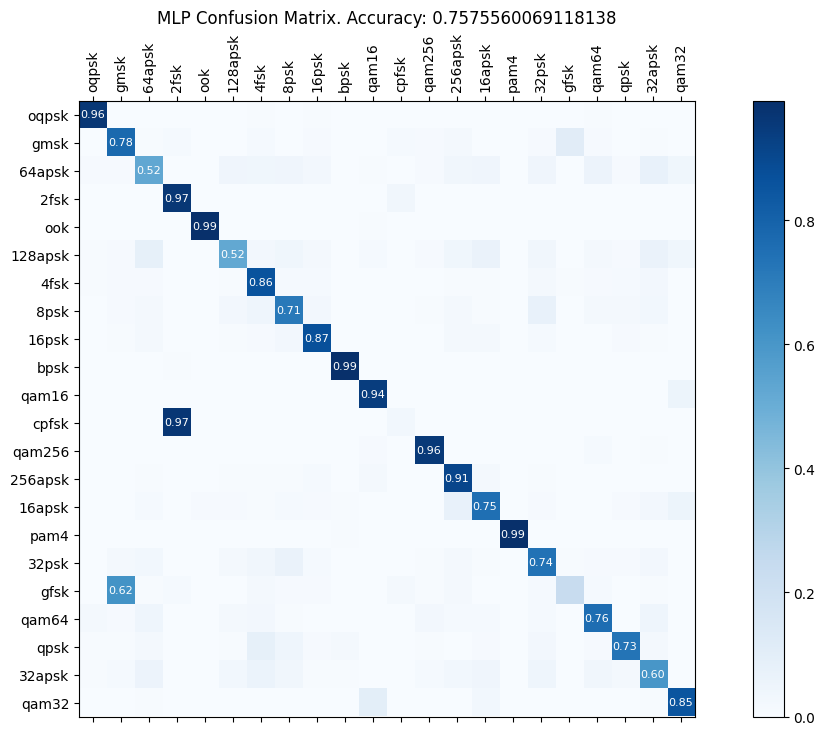

Performance of convnet
              precision    recall  f1-score   support

       oqpsk       0.98      0.99      0.99      2999
        gmsk       0.59      0.37      0.46      2999
      64apsk       0.75      0.73      0.74      2999
        2fsk       0.50      0.21      0.29      2999
         ook       1.00      1.00      1.00      2999
     128apsk       0.83      0.62      0.71      2999
        4fsk       0.93      1.00      0.96      2999
        8psk       0.90      0.84      0.87      2999
       16psk       0.91      0.91      0.91      2999
        bpsk       0.97      0.98      0.98      2999
       qam16       0.96      0.97      0.96      2998
       cpfsk       0.49      0.80      0.61      2999
      qam256       0.98      0.98      0.98      2999
     256apsk       0.86      0.97      0.91      2998
      16apsk       0.92      0.90      0.91      2998
        pam4       1.00      1.00      1.00      2999
       32psk       0.81      0.86      0.83      2999
    

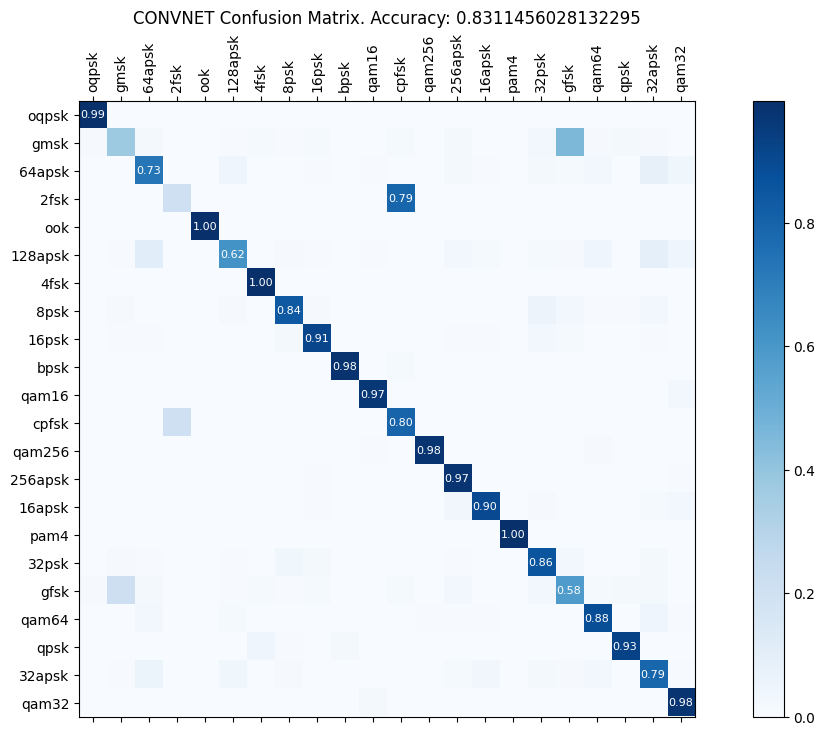

In [78]:
# visualize the results
# compute the accuracy, precision, recall, f1-score
# and the confusion matrix for each model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

plt.rcParams['figure.figsize'] = [15, 8]

labels = ['oqpsk', 'gmsk', '64apsk', '2fsk', 'ook', '128apsk', '4fsk', '8psk', '16psk', 'bpsk', 'qam16',
          'cpfsk', 'qam256', '256apsk', '16apsk', 'pam4', '32psk', 'gfsk', 'qam64', 'qpsk', '32apsk', 'qam32']
for model_name, result in results.items():
    print(f'Performance of {model_name}')
    print(classification_report(
        result['labels'], result['preds'], target_names=labels))
    acc = accuracy_score(result['labels'], result['preds'])
    print('Accuracy:', acc)
    conf_mat = confusion_matrix(
        result['labels'], result['preds'], normalize='true')
    ax = plt.subplot()
    im = ax.matshow(conf_mat, cmap='Blues')
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticklabels(labels)
    ax.title.set_text(
        f'{model_name.upper()} Confusion Matrix. Accuracy: {acc}')
    plt.colorbar(im)

    for (i, j), val in np.ndenumerate(conf_mat):
        if val < 0.5:
            continue
        ax.text(j, i, f'{val:.2f}', ha='center', va='center',
                color='white', fontsize=8)

    plt.show()

Observations from the experiment include the following:

1. The performance of the ConvNet is not comparable to that of the MLP. There is significant gains with the ConvNet architecture
2. Both architectures struggle to classify class with similar signal characteristics eg. gmsk and gfsk, cpfsk and 2fsk